In [1]:
import sys
import os
import glob
import numpy as np
import torch
from PIL import Image

In [2]:
data_name_list = sorted(glob.glob('../T91/*.png'))

In [3]:
class GetTrainData(object):
    def __init__(self, data_path_list):
        self.data_path_list = data_path_list
    def get_data(self):
        X, Y = [], []
        for i in range(len(self.data_path_list)):
            img = Image.open(self.data_path_list[i]).convert('L')
            (hight, width) = img.size
            if((width<128)|(hight<128)):
                continue
            img_array = np.array(img).astype(np.uint8)
            for w in range(0, width-128+1, 64):
                for h in range(0, hight-128+1, 64):
                    batch_img_array = img_array[w:w+128, h:h+128]
                    Y.append(batch_img_array.reshape(128,128,1))
                    batch_img = Image.fromarray(batch_img_array)
                    batch_img = batch_img.resize((64, 64), Image.BICUBIC)
                    batch_img = np.array(batch_img).astype(np.uint8)
                    X.append(batch_img.reshape(64,64,1))
        X = np.array(X)
        Y = np.array(Y)
        return X/255.0, Y/255.0

In [4]:
X, Y = GetTrainData(data_name_list).get_data()

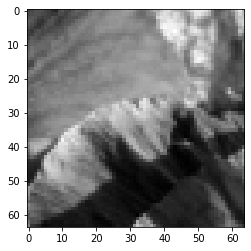

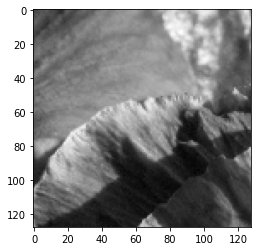

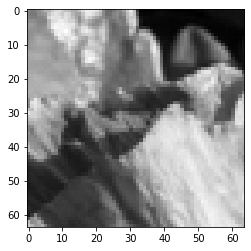

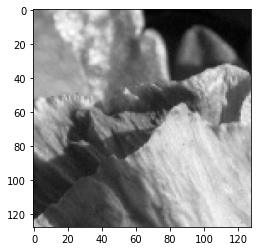

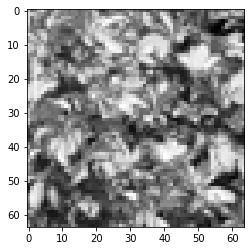

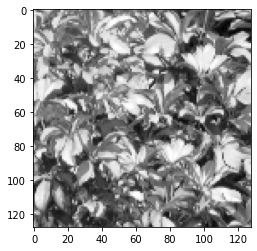

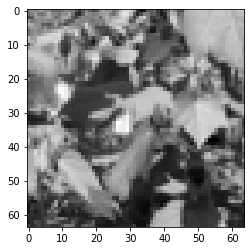

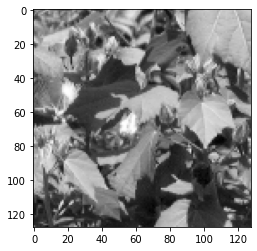

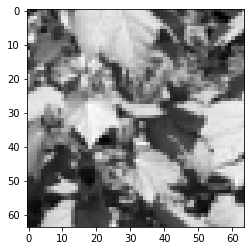

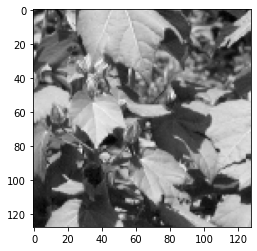

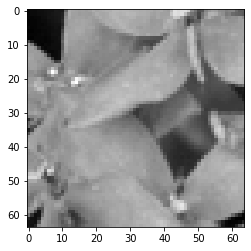

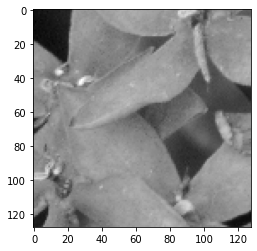

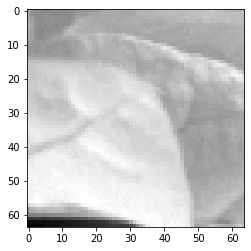

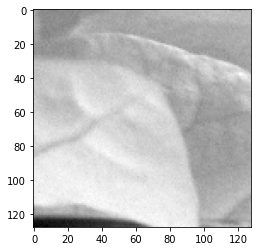

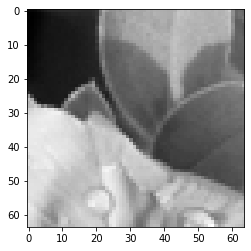

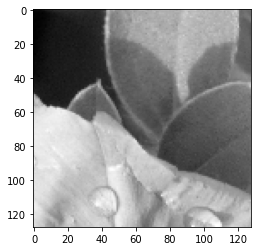

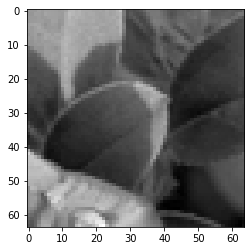

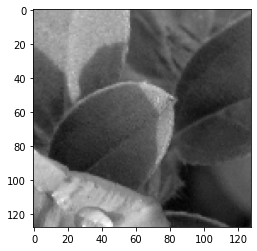

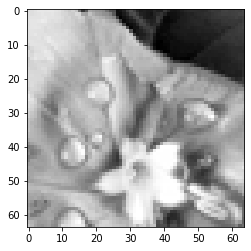

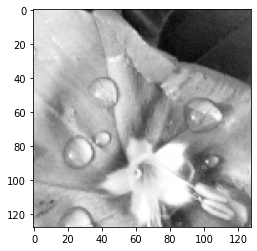

In [5]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.figure()
    plt.gray()
    plt.imshow(X[i].reshape(64, 64))
    plt.figure()
    plt.gray()
    plt.imshow(Y[i].reshape(128, 128))

In [6]:
print(f'LR image size = {X.shape}')
print(f'HR image size = {Y.shape}')
X = X.transpose(0, 3, 1, 2)
Y = Y.transpose(0, 3, 1, 2)
print(f'LR image size = {X.shape}')
print(f'HR image size = {Y.shape}')

LR image size = (501, 64, 64, 1)
HR image size = (501, 128, 128, 1)
LR image size = (501, 1, 64, 64)
HR image size = (501, 1, 128, 128)


In [7]:
import torch.utils.data
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.data = x
        if y is not None:
            self.label = y
        else:
            self.label = None

        self.datanum = x.shape[0]

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = torch.from_numpy(self.data[idx])
        if self.label is not None:
            out_label = torch.from_numpy(self.label[idx])
            return out_data, out_label
        else:
            return out_data

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
class Discriminator(nn.Module):
    def __init__(self, input_size = 256):
        super(Discriminator,self).__init__()

        self.conv_layers=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True))#(512,16,16)
        d_size = int(input_size//16)
        self.dense_layer=nn.Sequential(
            nn.Linear(d_size*d_size*512,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1),
            nn.Sigmoid())

    def forward(self,input_image):
        batch_size=input_image.size()[0]

        conv=self.conv_layers(input_image)
        #print(conv.size())
        reshape=conv.view(batch_size,-1)
        #print(reshape.size())
        output=self.dense_layer(reshape)

        return output

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
class Model(nn.Module):
    def __init__(self, d=48, s=12, m=2, upscale = 2):
        super().__init__()
        
        #feature extraction layer
        self.fe_layer = nn.Conv2d(in_channels=1, out_channels=d, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #shrinking layer
        self.sh_layer = nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        #mapping layer
        self.m = m
        for i in range(m):
            setattr(self, f'map_layer{i+1}', nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros'))
        
        #expanding layer
        self.ex_layer = nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        #deconv layer
        self.deconv = nn.ConvTranspose2d(in_channels=d, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1, groups=1, bias=True, dilation=1, padding_mode='zeros')
        self.deconv1 = nn.Conv2d(in_channels=d, out_channels=upscale**2, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.deconv2 = nn.PixelShuffle(upscale_factor=upscale)
        
        self.relu = nn.ReLU()
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        out = self.prelu(self.fe_layer(x))
        #res_out0 = out
        #print(out.size())
        out = self.prelu(self.sh_layer(out))
        res_out1 = out
        #print(out.size())
        for i in range(self.m):
            out = self.prelu(getattr(self, f'map_layer{i+1}')(out))
            #print(out.size())
        out = self.prelu(self.ex_layer(out+res_out1))
        #print(out.size())
        #out = self.deconv(out)
        #print(out.size())
        out = self.deconv1(out)
        #print(out.size())
        out = self.relu(self.deconv2(out))
        #print(out.size())
        return out

In [10]:
from torchvision import models
def generator_loss(generated_image, hr_image, d_label, t_label):
    vgg = models.vgg16(pretrained = True)
    content_layers = nn.Sequential(*list(vgg.features)[:31]).to(torch.device("cuda:0")).eval()
    for param in content_layers.parameters():
        param.requires_grad = False
    
    #入力画像を1ch→3chに拡張
    generated_image = torch.cat((generated_image, generated_image, generated_image), 1)
    hr_image = torch.cat((hr_image, hr_image, hr_image), 1)
    #print(generated_image.size())
    #print(hr_image.size())
    
    mse_loss = nn.MSELoss()
    #content_loss = mse_loss(generated_image, hr_image)
    content_loss = mse_loss(content_layers(generated_image), content_layers(hr_image))
    
    BCE_loss = nn.BCELoss()
    adversarial_loss = BCE_loss(d_label, t_label)
    return content_loss+0.001*adversarial_loss
import time
class FSRGAN(object):
    def __init__(self, path = None, img_size = 128, MAX_EPOCH = 100, BATCH_SIZE = 32, lr = 0.00001, upscale=2, d=48, s=12, m=2):
        self.MAX_EPOCH = MAX_EPOCH
        self.BATCH_SIZE = BATCH_SIZE
        self.lr = lr
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.G = Model(d=d, s=s, m=m, upscale=2)
        self.G = self.G.to(self.device)
        #FSRCNNのモデル読み出し
        if path is None:
            path = './model.pth'
        self.G.load_state_dict(torch.load(path))
        
        self.D = Discriminator(img_size)
        self.D = self.D.to(self.device)
        
        self.G_optimizer = optim.Adam(self.G.parameters(), lr = 0.0001, betas=(0.9, 0.999))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr = 0.0001, betas=(0.9, 0.999))
        
        self.d_loss = nn.BCELoss()

    def fit(self, X, Y):
        dataset = Mydatasets(X, Y)
        self.G_loss_list = []
        self.D_loss_list = []
        #ラベルの作成
        t_real = torch.ones(self.BATCH_SIZE, 1)
        t_fake = torch.zeros(self.BATCH_SIZE, 1)
        t_real = t_real.to(self.device)
        t_fake = t_fake.to(self.device)
        
        for epoch in range(self.MAX_EPOCH):
            loader = torch.utils.data.DataLoader(dataset, batch_size=self.BATCH_SIZE, shuffle=True, num_workers = 2)
            G_running_loss = 0.0
            D_running_loss = 0.0
            for batch_idx, (LR_img, HR_img) in enumerate(loader):
                if LR_img.size(0) != self.BATCH_SIZE:
                    break
                LR_img, HR_img = Variable(LR_img.float()).to(self.device), Variable(HR_img.float()).to(self.device)
                
                self.D_optimizer.zero_grad()
                
                
                #Dの学習
                D_real = self.D(HR_img)
                D_real_loss = self.d_loss(D_real, t_real)
                
                fake_img = self.G(LR_img)
                D_fake = self.D(fake_img)
                D_fake_loss = self.d_loss(D_fake, t_fake)
                
                D_loss = D_real_loss+D_fake_loss
                D_loss.backward(retain_graph = True)
                self.D_optimizer.step()
                D_running_loss+=D_loss.item()
                
                #Gの学習
                self.G_optimizer.zero_grad()
                fake_img = self.G(LR_img)
                D_fake = self.D(fake_img)
                G_loss = generator_loss(fake_img, HR_img, D_fake, t_real)
                G_loss.backward()
                self.G_optimizer.step()
                G_running_loss+=G_loss.item()

            print(f'Epoch[{epoch+1}/{self.MAX_EPOCH}]  G_loss : {G_running_loss/len(loader)} D_loss : {D_running_loss/len(loader)}')
            self.G_loss_list.append(G_running_loss/len(loader))
            self.D_loss_list.append(D_running_loss/len(loader))
        print(f'Finish training...')
        
    def transform(self, X):
        self.G.eval()
        dataset = Mydatasets(X)
        loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
        transformed_X = []
        total_time = 0.0
        for batch_idx, inputs in enumerate(loader):
            inputs = Variable(inputs.float()).to(self.device)
            start = time.time()
            outputs = self.G(inputs).squeeze(0).cpu().detach().numpy()
            end = time.time()
            total_time+=(end-start)
            transformed_X.append(outputs)
        print(f'Average transform time = {total_time/len(loader)}')
        return np.array(transformed_X)
    
    def save_model(self, path=None):
        if path is None:
            path = './G_model.pth'
        torch.save(self.G.state_dict(), path)
        print("SAVE MODEL SUCCESS!!")

In [11]:
fsrcnn = FSRGAN(path = './G_model.pth' ,MAX_EPOCH = 100, BATCH_SIZE=16)

In [12]:
transformed_X = fsrcnn.transform(X)
SR_image = transformed_X.transpose(0, 2, 3, 1)
HR_image = Y.transpose(0, 2, 3, 1)

Average transform time = 0.0005359682970180245


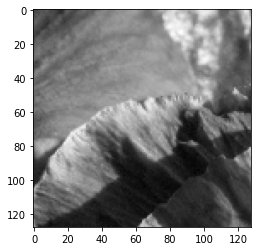

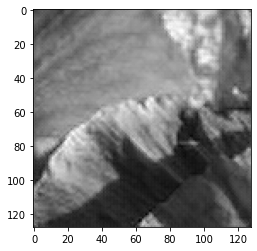

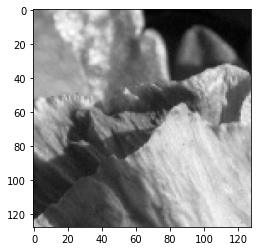

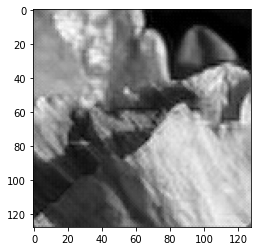

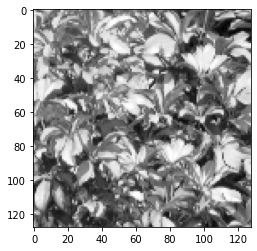

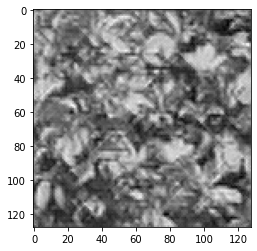

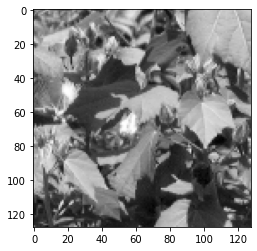

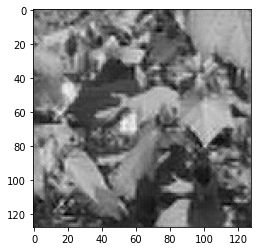

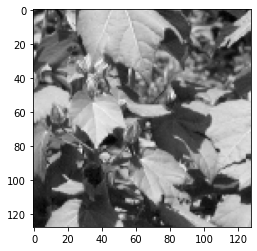

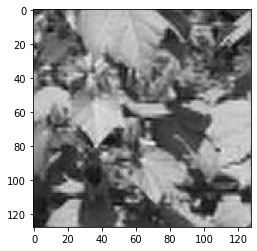

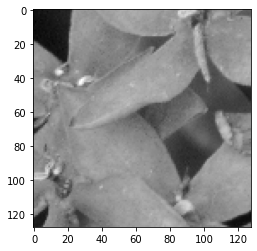

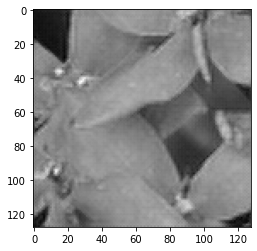

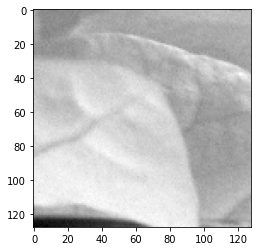

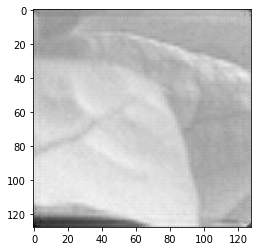

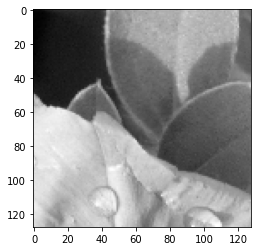

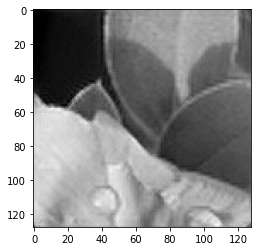

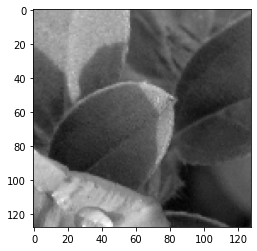

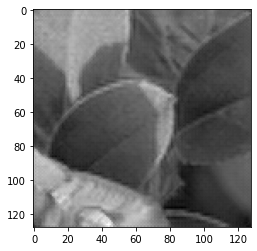

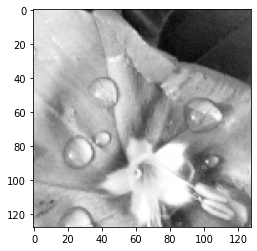

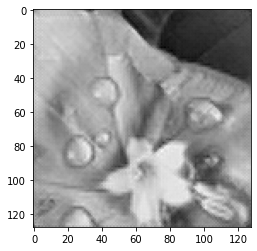

In [13]:
for i in range(10):
    plt.figure()
    plt.gray()
    plt.imshow(HR_image[i])
    plt.figure()
    plt.gray()
    plt.imshow(SR_image[i])

In [14]:
fsrcnn.save_model()

SAVE MODEL SUCCESS!!
